In [15]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob as gb
from tensorflow import keras

In [16]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[]

In [17]:
IMG_SIZE = (128, 128)  # Resize all images to 128x128
BATCH_SIZE = 64
TRAIN_DIR = "D:/software engineering/image analysis project/Data/"
class_names = ['angry', 'happy', 'sad']

## Remove dodgy images

In [18]:
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(TRAIN_DIR): 
    for image in os.listdir(os.path.join(TRAIN_DIR, image_class)):
        image_path = os.path.join(TRAIN_DIR, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [19]:
data = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",  # This is for multi-class classification
    shuffle=True
)


Found 2625 files belonging to 3 classes.


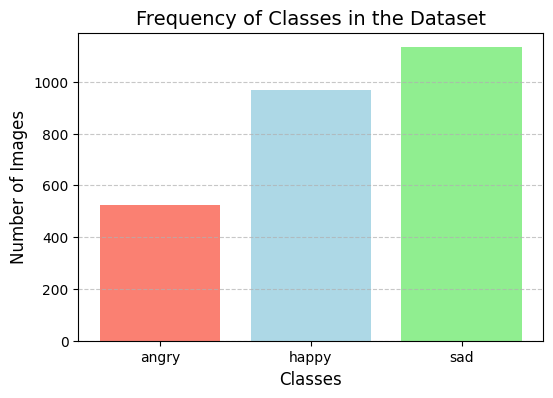

In [37]:
# Count the number of images per class
class_counts = {class_name: 0 for class_name in class_names}
for images, labels in data:
    for label in labels:
        class_index = tf.argmax(label).numpy()
        class_counts[class_names[class_index]] += 1

plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color=['salmon', 'lightblue', 'lightgreen'])
plt.title("Frequency of Classes in the Dataset", fontsize=14)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Normalize Data

In [20]:
# Normalize pixel values to range [0, 1]
data = data.map(lambda x, y: (x / 255.0, y))

scaled_iterator = data.as_numpy_iterator()
scaled_batch = scaled_iterator.next()
print(f"Scaled Batch Image Shape: {scaled_batch[0].shape}, Batch Label Shape: {scaled_batch[1].shape}")


Scaled Batch Image Shape: (64, 128, 128, 3), Batch Label Shape: (64, 3)


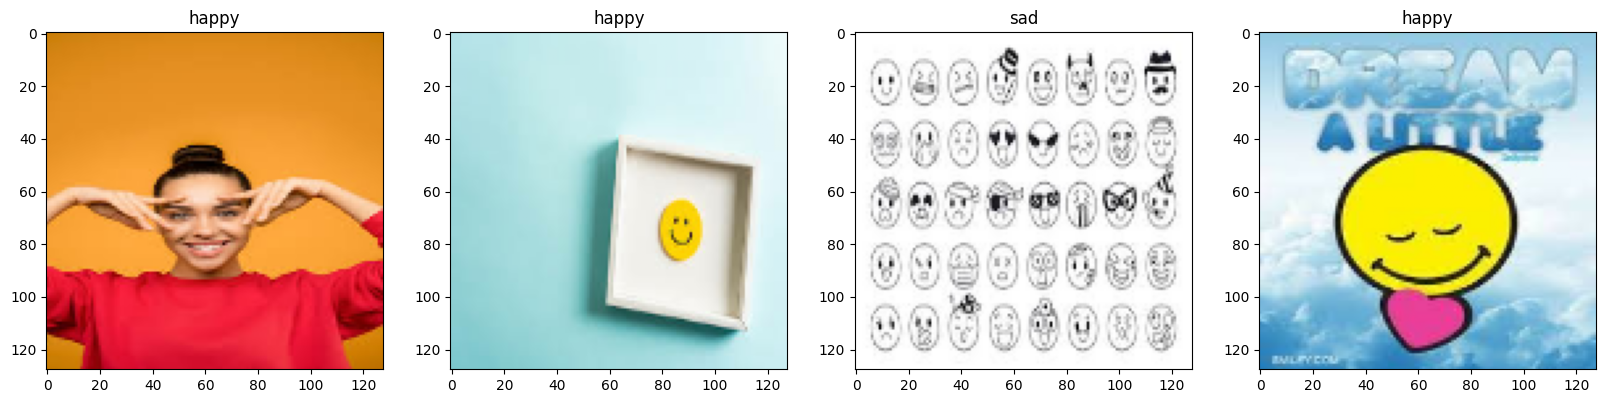

In [21]:
# Visualize normalized images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img)  
    ax[idx].title.set_text(class_names[tf.argmax(scaled_batch[1][idx])])
plt.show()

In [22]:
len(data)

42

## Split Data

In [23]:
# Split dataset into train, validation, and test sets
total_batches = len(data)
train_size = int(total_batches * 0.8)
val_size = int(total_batches * 0.1)
test_size = total_batches - train_size - val_size

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

print(f"Train size: {train_size} batches")
print(f"Validation size: {val_size} batches")
print(f"Test size: {test_size} batches")

Train size: 33 batches
Validation size: 4 batches
Test size: 5 batches


## CNN Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



d:\anacondas\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,803 (24.86 MB)

 Trainable params: 6,516,803 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    train,
    validation_data=val,  
    epochs=150,
    
)


Epoch 1/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 467ms/step - accuracy: 0.4198 - loss: 1.0612 - val_accuracy: 0.5664 - val_loss: 0.9887
Epoch 2/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 484ms/step - accuracy: 0.5117 - loss: 0.9898 - val_accuracy: 0.5820 - val_loss: 0.9179
Epoch 3/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 493ms/step - accuracy: 0.5590 - loss: 0.9150 - val_accuracy: 0.6133 - val_loss: 0.8558
Epoch 4/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 477ms/step - accuracy: 0.5757 - loss: 0.8821 - val_accuracy: 0.5781 - val_loss: 0.8816
Epoch 5/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 488ms/step - accuracy: 0.6140 - loss: 0.8448 - val_accuracy: 0.6289 - val_loss: 0.8301
Epoch 6/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 531ms/step - accuracy: 0.6095 - loss: 0.8303 - val_accuracy: 0.6484 - val_loss: 0.7801
Epoch 7/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 516ms/step - accuracy: 0.6451 - loss: 0.7892 - val_accuracy: 0.6445 - val_loss: 0.8106
Epoch 8/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 520ms/step - accuracy: 0.6411 - loss: 0.7659 - 

## Performance

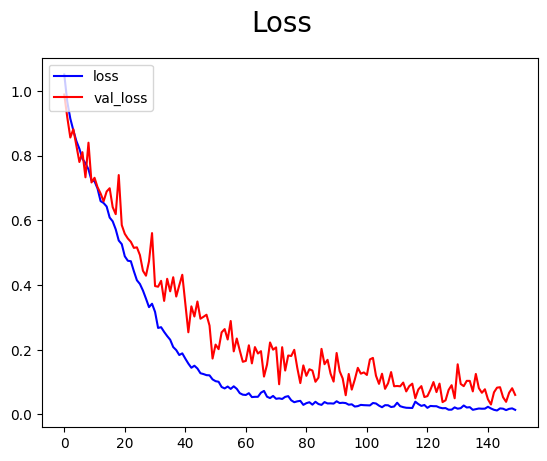

In [27]:
fig = plt.figure()
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

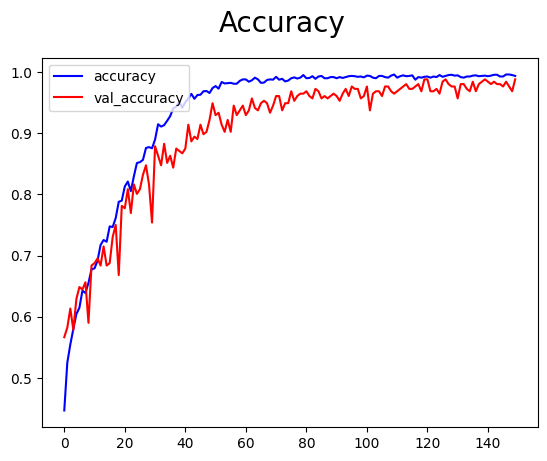

In [28]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [29]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step - accuracy: 0.9818 - loss: 0.1010
Validation Accuracy: 98.05%


In [30]:
model.save('sentiment.h5')  # Save the model 


In [31]:
from tensorflow.keras.models import load_model

loaded_model = keras.models.load_model('sentiment.h5')


## Testing 

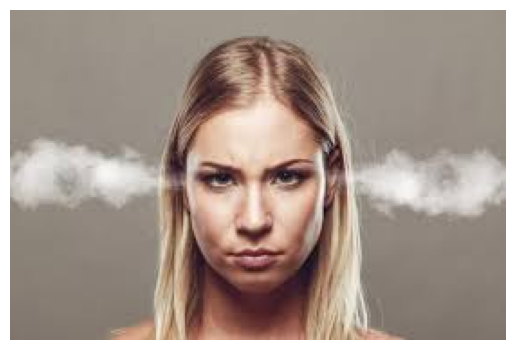

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted Class Index: 0
Predicted Emotion: Angry


In [38]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

class_labels = {
    0: "Angry",
    1: "Happy",
    2: "Sad",
}

image = cv2.imread("D:/software engineering/image analysis project/angry.jpeg")

if image is None:
    print("Error: Could not read the image. Check the file path.")
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_fromarray = Image.fromarray(image_rgb, 'RGB')
    resize_image = image_fromarray.resize((128, 128))
    
    expand_input = np.expand_dims(resize_image, axis=0)
    input_data = np.array(expand_input) / 255.0
    
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()
    
    pred = loaded_model.predict(input_data)
    result = pred.argmax() 
    

    emotion = class_labels.get(result, "Unknown")
    
    print(f"Predicted Class Index: {result}")
    print(f"Predicted Emotion: {emotion}")
